# Power Spectrum Summary

**by Josh Dillon**, last updated October 28, 2024

The purpose of this notebook is to pull together results from power spectra from single, redundantly-averaged baselines (typically cross-power spectra from interleaved sets of times) as produced by the [Single Baseline Filtering and Power Spectrum Estimation
notebook](https://github.com/HERA-Team/hera_notebook_templates/blob/master/notebooks/single_baseline_postprocessing_and_pspec.ipynb). It is supposed to be roughly comparable to [a similar notebook from H1C](https://github.com/HERA-Team/H1C_IDR3_Power_Spectra/blob/main/SPOILERS/All_Epochs_Power_Spectra/H1C_IDR3_Power_Spectra.ipynb).

# [• Figure 1: P(k) Averaged Over Baseline vs. LST](#Figure-1:-P(k)-Averaged-Over-Baseline-vs.-LST)
# [• Figure 2: Per-Baseline Signal Loss Corrections](#Figure-2:-Per-Baseline-Signal-Loss-Corrections)
# [• Figure 3: Per-Baseline, Time-Averaged High Delay Average SNR](#Figure-3:-Per-Baseline,-Time-Averaged-High-Delay-Average-SNR)
# [• Figure 4: Histograms of Time-Averaged High-Delay SNRs](#Figure-4:-Histograms-of-Time-Averaged-High-Delay-SNRs)
# [• Figure 5: Time-Averaged Cylindrical P(k)](#Figure-5:-Time-Averaged-Cylindrical-P(k))
# [• Figure 6: Time-Averaged Cylindrical SNR](#Figure-6:-Time-Averaged-Cylindrical-SNR)
# [• Figure 7: Spherically-Averaged $\Delta^2$](#Figure-7:-Spherically-Averaged-%24%5CDelta%5E2%24)
# [• Table 1: Power Spectra, Error Bars, and Upper Limits](#Table-1:-Power-Spectra,-Error-Bars,-and-Upper-Limits)

In [1]:
import time
tstart = time.time()

In [2]:
import os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
import h5py
import hdf5plugin  # REQUIRED to have the compression plugins available
import numpy as np
import glob
import copy
import pandas as pd
import pickle
from hera_cal import io, utils
import hera_pspec as hp
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
from scipy import constants
from IPython.core.display import display, HTML
%matplotlib inline

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display


In [14]:
# Data settings
PSPEC_FOLDER: str = '/lustre/aoc/projects/hera/Validation/H6C_IDR2/lstbin-outputs/redavg-smoothcal-inpaint-500ns-lstcal-siminpaint/inpaint/single_baseline_files/'
PSPEC_SUFFIX: str = "pspec.h5"

# Output Files
RESULTS_FOLDER: str = '/lustre/aoc/projects/hera/Validation/H6C_IDR2/pspec-outputs/simultaneous-inpaint/'
CASENAME: str = "all_baselines_interleaved_IDR2.3_500ns_14band"
RELOAD_PSPEC: bool = False

# Analysis Options
BANDS_TO_USE: str = "1,2,3,5,6,9,10,13"
WEDGE_BUFFER_NS: float = 500.0
MAX_FRF_SIGNAL_LOSS: float = 0.1
LST_MIN: float = 1.5
LST_MAX: float = 5.5

In [15]:
# Some simple formatting of the inputs

BANDS_TO_USE = [int(band) for band in BANDS_TO_USE.split(",")] # 1 indexed

if LST_MIN > LST_MAX:
    LST_MIN -= 24

RESULTS_FOLDER = Path(RESULTS_FOLDER)
COMBINED_PSPEC_FILE = RESULTS_FOLDER / f'{CASENAME}.pspec.h5'
COHERENT_AVG_CORRECTION_FACTOR_FILE = RESULTS_FOLDER / f'{CASENAME}.coherent_avg_correction_factor.p'
FRF_SIGNAL_LOSS_FILE = RESULTS_FOLDER / f'{CASENAME}.frf_signal_loss.p'

PSPEC_FOLDER = Path(PSPEC_FOLDER)

## Load Power Spectra and Apply Bias Corrections

**TODO:**
* Ensure that when Mike's updated FRF errorbars are added, the correction factor for time-averaged power spectra is correctly propagated: dpss_coherent_avg_corrections
* Calculate signal loss due to redundant averaging

In [16]:
pspec_files = sorted(PSPEC_FOLDER.glob(f'*.{PSPEC_SUFFIX}'))
print(f"Found {len(pspec_files)} *.{PSPEC_SUFFIX} in files starting with {pspec_files[0]}.")

Found 789 *.pspec.h5 in files starting with /lustre/aoc/projects/hera/Validation/H6C_IDR2/lstbin-outputs/redavg-smoothcal-inpaint-500ns-lstcal-siminpaint/inpaint/single_baseline_files/zen.LST.baseline.0_1.sum.pspec.h5.


In [17]:
def bias_correction(uvp, total_bias=None, data_bias=None):
    """
    Apply correction factors to power spectra. Operates inplace.

    Args:
        uvp : UVPSpec object
        total_bias : dict
            bias correction to data and errors, e.g. abscal bias
            keys are spw integers, values are correction scalars
        data_bias : dict
            bias correction only to data, e.g. fringe-rate filtering
            keys are spw integers, values are correction scalars
    """
    for spw in uvp.spw_array:
        if total_bias is not None:
            uvp.data_array[spw] *= total_bias[spw]
            if hasattr(uvp, 'cov_array_real'):
                uvp.cov_array_real[spw] *= total_bias[spw]**2
                uvp.cov_array_imag[spw] *= total_bias[spw]**2
            if hasattr(uvp, 'stats_array'):
                for stat in uvp.stats_array:
                    uvp.stats_array[stat][spw] *= total_bias[spw]
                    # TODO: this is right for P_N but not quite right for P_SN (though I'm not sure how much we care)
        if data_bias is not None:
            uvp.data_array[spw] *= data_bias[spw]

In [18]:
if RELOAD_PSPEC or not os.path.exists(COMBINED_PSPEC_FILE):
    uvp_by_blp = {}
    dpss_coherent_avg_corrections = {}
    frf_losses = {}
    
    for df in pspec_files:
        # load power spectra
        psc = hp.container.PSpecContainer(df, mode='r', keep_open=False)
        uvp = psc.get_pspec('stokespol', 'interleave_averaged') # TODO: GENERALIZE
        blp = uvp.get_blpairs()[0]    
        uvp_by_blp[blp] = uvp
    
        # load additional metadata stored in header
        with h5py.File(df, 'r') as f:
            dpss_coherent_avg_corrections[blp] = f['header'].attrs['dpss_coherent_avg_corrections']
            # TODO: ensure that that this factor is 
            frf_losses[blp] = f['header'].attrs['frf_losses']
        
        # apply FRF loss bias correction
        bias_correction(uvp_by_blp[blp], data_bias={spw: (1.0 - loss)**-1 for spw, loss in enumerate(frf_losses[blp])})

    # write dpss_coherent_avg_corrections to a pickle
    with open(COHERENT_AVG_CORRECTION_FACTOR_FILE, 'wb') as f:
        pickle.dump(dpss_coherent_avg_corrections, f)
    with open(FRF_SIGNAL_LOSS_FILE, 'wb') as f:
        pickle.dump(frf_losses, f)
    
    uvp = hp.uvpspec.recursive_combine_uvpspec(list(uvp_by_blp.values()))
    psc = hp.PSpecContainer(COMBINED_PSPEC_FILE, mode='rw', keep_open=False)
    psc.set_pspec('stokespol', 'all_baselines', uvp, overwrite=True) 
else:
    # read previously calculated results
    psc = hp.PSpecContainer(COMBINED_PSPEC_FILE, mode='rw', keep_open=False)
    uvp = psc.get_pspec('stokespol', 'all_baselines')
    with open(COHERENT_AVG_CORRECTION_FACTOR_FILE, 'rb') as f:
        dpss_coherent_avg_corrections = pickle.load(f)
    with open(FRF_SIGNAL_LOSS_FILE, 'rb') as f:
        frf_losses = pickle.load(f)

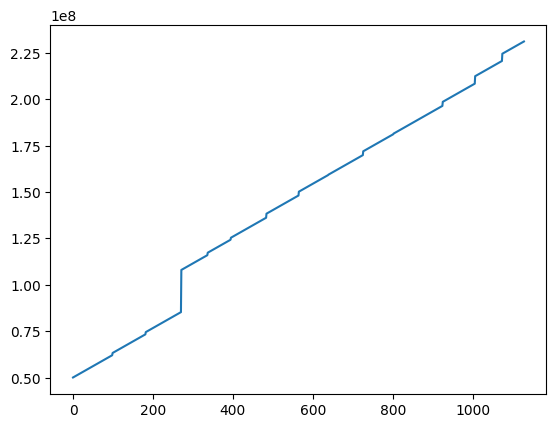

In [21]:
plt.plot(uvp.freq_array)

In [19]:
out = []
for spw in uvp.spw_array:
    idxs = np.argwhere(uvp.spw_freq_array==spw)
    out.append(f"{idxs.min()}~{idxs.max()+1}")
print(",".join(out))

0~99,99~182,182~271,271~337,337~395,395~484,484~565,565~639,639~726,726~802,802~925,925~1006,1006~1074,1074~1129


In [ ]:
dlst = np.median(np.diff(uvp.lst_avg_array[uvp.key_to_indices((0, ((0, 1), (0, 1)), ('pI', 'pI')))[1]]))
all_lsts = np.unique(uvp.lst_avg_array)
all_lsts[all_lsts * 12 / np.pi > 17.75] -= 2 * np.pi
lst_grid = np.arange(np.min(all_lsts) - dlst, np.max(all_lsts) + dlst, dlst)

In [ ]:
# select a subset of bands to analyze. From now on, bands will be re-numbered
uvp.select(spws=[b - 1 for b in BANDS_TO_USE])
# select pI and pQ (ignore pU and pV, which are experimental)
uvp.select(polpairs=[('pI', 'pI'), ('pQ', 'pQ')])

In [ ]:
# dict to map baseline pairs to baseline vectors
blp_to_blvec_dict = {blp: blpv for blp, blpv in zip(uvp.get_blpairs(), uvp.get_blpair_blvecs())}

In [ ]:
# get mean redshifts for each spw
zs = np.array([np.mean(1.420405751e9 / uvp.freq_array[uvp.spw_freq_array == spw] - 1) for spw in uvp.spw_array])

## Examine LST structure of the power spectrum

In [ ]:
# build dictionary mapping an individual baseline's LST range to the wider set of LSTs
blp_to_lst_indices = {}
for key in uvp.get_all_keys():
    if not key[1] in blp_to_lst_indices:
        lsts = uvp.lst_avg_array[uvp.key_to_indices(key)[1]]
        lsts[lsts * 12 / np.pi > 17.75] -= 2 * np.pi    
        blp_to_lst_indices[key[1]] = np.searchsorted(lst_grid, lsts[0]) + np.arange(len(lsts), dtype=int)

In [ ]:
wgts_sum = {spw: np.zeros((len(lst_grid), len(uvp.get_dlys(spw)))) for spw in uvp.spw_array}
pI_sum = {spw: np.zeros((len(lst_grid), len(uvp.get_dlys(spw))), dtype=complex) for spw in uvp.spw_array}
pQ_sum = {spw: np.zeros((len(lst_grid), len(uvp.get_dlys(spw))), dtype=complex) for spw in uvp.spw_array}

# average power spectra over baselines
for key in list(uvp.get_all_keys()):
    spw, blp, pp = key
    if pp != ('pI', 'pI'):
        continue

    # inverse variance weight baselines
    wgt = np.abs(uvp.get_stats('P_N', key))**-2
    
    wedge_plus_buffer = np.linalg.norm(np.linalg.norm(blp_to_blvec_dict[key[1]])) / constants.c + WEDGE_BUFFER_NS * 1e-9
    wgt[:, np.abs(uvp.get_dlys(spw)) < wedge_plus_buffer] = 0
    pI_sum[spw][blp_to_lst_indices[blp], :] += uvp.get_data(key) * wgt
    pQ_sum[spw][blp_to_lst_indices[blp], :] += uvp.get_data((spw, blp, ('pQ', 'pQ'))) * wgt
    wgts_sum[spw][blp_to_lst_indices[blp], :] += wgt

# normalize average
for spw in pI_sum:
    pI_sum[spw] /= wgts_sum[spw]
    pQ_sum[spw] /= wgts_sum[spw]

In [ ]:
def plot_power_spectrum_avg_vs_LST():
    fig, axes = plt.subplots(len(uvp.spw_array), 2, figsize=(8, len(uvp.spw_array) * 2), sharey=True, sharex=True, gridspec_kw={'wspace': 0, 'hspace': 0})
    
    for spw, ax in enumerate(axes):
        dlys = uvp.get_dlys(spw) * 1e9
        
        im = ax[0].imshow(pI_sum[spw].real, aspect='auto', interpolation='none', cmap='turbo', norm=matplotlib.colors.LogNorm(vmin=1e5, vmax=1e13), 
                          extent=[dlys[0], dlys[-1], lst_grid[-1] * 12 / np.pi, lst_grid[0] * 12 / np.pi])
    
        im = ax[1].imshow(pQ_sum[spw].real, aspect='auto', interpolation='none', cmap='turbo', norm=matplotlib.colors.LogNorm(vmin=1e5, vmax=1e13), 
                          extent=[dlys[0], dlys[-1], lst_grid[-1] * 12 / np.pi, lst_grid[0] * 12 / np.pi])
    
        
        for a in ax:
            a.set_xticks([-3000, -1500, 0, 1500, 3000])
            if spw == len(uvp.spw_array) - 1:
                a.set_xlabel('Delay (ns)')
        ax[0].set_yticks(ax[0].get_yticks())
        ax[0].set_yticklabels(['',] + list(ax[0].get_yticks() % 24)[1:])            
        ax[0].set_ylabel('LST (hours)')
    
        for a, pol in zip(ax, ['pI', 'pQ']):
            a.text(a.get_xlim()[0] + 300, a.get_ylim()[-1] + .4, f'{pol} Band {spw + 1}\nz = {zs[spw]:.1f}', ha='left', va='top',
                     bbox=dict(facecolor='w', edgecolor='black', alpha=.75, boxstyle='round', ls='-'))
            a.tick_params(axis='x', direction='in')
    
    
    plt.tight_layout()
    plt.colorbar(im, ax=axes, pad=.02, aspect=40, extend='both', location='top', label=f'Baselined-Averaged Outside Wedge + {WEDGE_BUFFER_NS} ns' + 'Re[$P(k)$] (mK$^2$ $h^{-3}$ Mpc$^3$)')
    plt.savefig(os.path.join(RESULTS_FOLDER, 'baseline_avg_vs_LST_all_bands_2pol.pdf'), bbox_inches='tight')

# Figure 1: P(k) Averaged Over Baseline vs. LST

In [ ]:
plot_power_spectrum_avg_vs_LST()

## Compute time-averaged statistics

In [ ]:
# pefrom time average in range set by LST_RANGE_HOURS
lst_subset = uvp.lst_avg_array[(uvp.lst_avg_array >= LST_MIN * np.pi / 12) & (uvp.lst_avg_array <= LST_MAX * np.pi / 12)]
uvp_tavg = uvp.select(lsts=lst_subset, polpairs=[('pI', 'pI')], inplace=False)
uvp_tavg.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'], inplace=True)

In [ ]:
# correct noise statistics by the coherent average correction factor, which accounts for the FRF
for key in uvp_tavg.get_all_keys():
    uvp_tavg.set_stats('P_N', key, uvp_tavg.get_stats('P_N', key) * dpss_coherent_avg_corrections[key[1]][key[0]]**.5)
    uvp_tavg.set_stats('P_SN', key, uvp_tavg.get_stats('P_SN', key) * dpss_coherent_avg_corrections[key[1]][key[0]]**.5)
    # TODO: Jianrong to figure out whether P_SN should be treated differently here

In [ ]:
def plot_baseline_signal_loss():
    # Show signal loss correction applied to each baseline as a function of spectral window, highlighting those with too much signal loss 
    fig, axes = plt.subplots(int(np.ceil(uvp.Nspws / 2)),2, figsize=(12, 12), sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace':0})
    
    for spw, ax in enumerate(axes.ravel()):
        if spw == len(uvp.spw_array):
            break
    
        bl_vecs = {}
        for key in uvp_tavg.get_all_keys():
            _spw, blp, pp = key
            if _spw != spw: 
                continue
            if pp[0] != 'pI':
                continue
            blv = blp_to_blvec_dict[blp]
            if blv[1] < 0:
                bl_vecs[blp] = -blv
            else:
                bl_vecs[blp] = blv
                    
        if spw % 2 == 0:
            ax.set_ylabel('NS Baseline Component (m)')
        if spw >= int(np.ceil(uvp.Nspws / 2)) - 2:
            ax.set_xlabel('EW Baseline Component (m)')
        
        blps = list(bl_vecs.keys())
        im = ax.scatter([bl_vecs[blp][0] for blp in blps], [bl_vecs[blp][1] for blp in blps], c=[frf_losses[blp][spw] for blp in blps], 
                        edgecolors=['r' if (frf_losses[blp][spw] > MAX_FRF_SIGNAL_LOSS) else 'none' for blp in blps], linewidths=.5,
                        s=20, cmap='viridis', vmin=0, vmax=min(2 * MAX_FRF_SIGNAL_LOSS, 1))
    
        ax.text(ax.get_xlim()[0] + 10, ax.get_ylim()[-1] - 10, f'Band {spw + 1}\nz = {zs[spw]:.1f}', ha='left', va='top',
                         bbox=dict(facecolor='w', edgecolor='black', alpha=.75, boxstyle='round', ls='-'))
        
    plt.tight_layout()
    plt.colorbar(im, ax=axes, pad=.02, aspect=40, extend='max', location='top', label=f'Signal Loss due to Fringe Rate and Cross Talk Filters')
    plt.savefig(os.path.join(RESULTS_FOLDER, 'per_baseline_signal_loss_all_bands.pdf'), bbox_inches='tight')

# Figure 2: Per-Baseline Signal Loss Corrections
Baselines outlined in red have too much signal loss and are excluded from the final power spectrum.

In [ ]:
plot_baseline_signal_loss()

In [ ]:
def plot_baseline_SNR():
    # Look for individual baselines with high SNR outside the wedge, a sign of a particular failure mode
    low_dly = 1000
    high_dly = 2000
    fig, axes = plt.subplots(int(np.ceil(uvp.Nspws / 2)),2, figsize=(12, 12), sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace':0})
    
    for spw, ax in enumerate(axes.ravel()):
        if spw == len(uvp.spw_array):
            break
        bl_vecs = {}
        pk_avgs = {}
        snr_avgs = {}
        dlys = uvp_tavg.get_dlys(spw) * 1e9
        dlys_to_use = (low_dly <= np.abs(dlys)) & (np.abs(dlys) <= high_dly)
        for key in uvp_tavg.get_all_keys():
            _spw, blp, pp = key
            if _spw != spw: 
                continue
            if pp[0] != 'pI':
                continue
            blv = blp_to_blvec_dict[blp]
            if blv[1] < 0:
                bl_vecs[blp] = -blv
            else:
                bl_vecs[blp] = blv
            pk_avgs[blp] = np.mean(uvp_tavg.get_data(key)[0, dlys_to_use].real)
            snr_avgs[blp] = pk_avgs[blp] / np.mean(uvp_tavg.get_stats('P_N', key)[0, dlys_to_use].real)
            
        if spw % 2 == 0:
            ax.set_ylabel('NS Baseline Component (m)')
        if spw >= int(np.ceil(uvp.Nspws / 2)) - 2:
            ax.set_xlabel('EW Baseline Component (m)')
        
        blps = list(bl_vecs.keys())
        
        im = ax.scatter([bl_vecs[blp][0] for blp in blps], [bl_vecs[blp][1] for blp in blps], c=[snr_avgs[blp] for blp in blps], 
                        edgecolors=['k' if (frf_losses[blp][spw] >= MAX_FRF_SIGNAL_LOSS) else 'none' for blp in blps], linewidths=.5,
                        s=20, cmap='bwr', vmin=-2, vmax=2)
    
        ax.text(ax.get_xlim()[0] + 10, ax.get_ylim()[-1] - 10, f'Band {spw + 1}\nz = {zs[spw]:.1f}', ha='left', va='top',
                         bbox=dict(facecolor='w', edgecolor='black', alpha=.75, boxstyle='round', ls='-'))
        
    plt.tight_layout()
    plt.colorbar(im, ax=axes, pad=.02, aspect=40, extend='both', location='top', label=f'Average $P(k) / P_N$ Between {low_dly} and {high_dly} ns')
    plt.savefig(os.path.join(RESULTS_FOLDER, 'per_baseline_SNR_all_bands.pdf'), bbox_inches='tight')

# Figure 3: Per-Baseline, Time-Averaged High Delay Average SNR
Baselines outlined in black have too much signal loss and are excluded from the final power spectrum.

In [ ]:
plot_baseline_SNR()

In [ ]:
def plot_SNR_histograms():
    # show the distribution of time-averaged power spectra (before spherical averaging)
    low_dly = 1000
    high_dly = 2000
    fig, axes = plt.subplots(int(np.ceil(uvp.Nspws / 2)), 2, figsize=(12, 12), sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace':0})
    
    for spw, ax in enumerate(axes.ravel()):
        if spw == len(uvp.spw_array):
            break
        to_hist = []
        dlys = uvp_tavg.get_dlys(spw) * 1e9
        dlys_to_use = (low_dly <= np.abs(dlys)) & (np.abs(dlys) <= high_dly)
        for key in uvp_tavg.get_all_keys():
            _spw, blp, pp = key
            if _spw != spw: 
                continue
            if pp[0] != 'pI':
                continue
            if frf_losses[blp][spw] > MAX_FRF_SIGNAL_LOSS:
                continue
            SNRs = uvp_tavg.get_data(key)[0, dlys_to_use] / uvp_tavg.get_stats('P_N', key)[0, dlys_to_use].real
            to_hist.extend(SNRs)
    
        bins = np.linspace(-10,10,101)        
        
        for func, c, zorder in zip([np.real, np.imag], ['C0', 'C1'], [2, 1]):
            ax.hist(func(to_hist), bins=bins, density=True, color=c, edgecolor='k', linewidth=.1, alpha=.5, zorder=zorder,
                    label=f'{"Re" if func == np.real else "Im"}[$P(k)$] / $P_N$ ({low_dly}—{high_dly} ns)')
        ax.set_yscale('log')
        ax.set_ylim([2e-5, 1e0])
        
        gauss = np.exp(-bins**2/2) / np.sqrt(2*np.pi)
        ax.plot(bins, gauss, 'k--', label='Gaussian Distribution')
    
        ax.text(ax.get_xlim()[0] + .6, ax.get_ylim()[-1] / 1.8, f'Band {spw + 1}\nz = {zs[spw]:.1f}', ha='left', va='top',
                bbox=dict(facecolor='w', edgecolor='black', alpha=.75, boxstyle='round', ls='-'))
        if spw % 2 == 0:
            ax.set_ylabel('Probability Density')
        if spw >= int(np.ceil(uvp.Nspws / 2)) - 2:
            ax.set_xlabel('SNR')
    
        if spw == 0:
            fig.legend(loc='upper center', ncol=3, fontsize=10)
    plt.tight_layout()
    fig.subplots_adjust(top=0.95)
    
    plt.savefig(os.path.join(RESULTS_FOLDER, 'SNR_histogram_all_bands.pdf'), bbox_inches='tight')

# Figure 4: Histograms of Time-Averaged High-Delay SNRs

In [ ]:
plot_SNR_histograms()

In [ ]:
def plot_cylindrical_Pk(SNR=False):
    # TODO: update to show k_|| and k_perp
    # TODO: update to show wedge buffer
    # TODO: exclude high signal loss baselines
    fig, axes = plt.subplots(int(np.ceil(uvp.Nspws / 2)),2, figsize=(12, 12), 
                             sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace':0})

    uvp_here = copy.deepcopy(uvp_tavg)
    
    for spw, ax in enumerate(axes.ravel()):
        if SNR:
            uvp_here.data_array[spw] /= uvp_here.stats_array['P_N'][spw].real
            extra_kwargs = dict(cmap='bwr', vmin=-2, vmax=2)
        else:
            extra_kwargs = dict(cmap='turbo', error_weights='P_N')
        
        hp.plot.delay_wedge(uvp_here, spw, ('pI', 'pI'), rotate=True, ax=ax, fold=True, log10=False, 
                            component='real',  horizon_lines=True, **extra_kwargs)

        cax = ax.collections[0]
        if not SNR:
            cax.set_norm(matplotlib.colors.LogNorm(vmin=1e2, vmax=1e14))

        if spw % 2 == 0:
            ax.set_ylabel('$\\tau$ (ns)', fontsize=10)
        else:
            ax.set_ylabel('')
        if uvp.Nspws - spw <= 2:
            ax.set_xlabel('$|\\vec{b}|$ (m)', fontsize=10)
        else:
            ax.set_xlabel('')
        ax.text(ax.get_xlim()[0] + 7, ax.get_ylim()[-1] - 200, f'Band {spw + 1}\nz = {zs[spw]:.1f}', ha='left', va='top',
                     bbox=dict(facecolor='w', edgecolor='black', alpha=.75, boxstyle='round', ls='-'))
        ax.tick_params(axis='both', direction='in')
    
    plt.tight_layout()
    cbar = fig.colorbar(cax, ax=axes, pad=.02, aspect=40, extend='both', location='top',
                        label=(r"$\text{Re}[P(k_\parallel, k_\perp)]\text{ }/\text{ }P_N(k_\parallel, k_\perp)$" if SNR
                               else r"$\text{Re}[P(k_\parallel, k_\perp)]\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$"))
    plt.savefig(os.path.join(RESULTS_FOLDER, (f'cylindrical_{"SNR" if SNR else "Pk"}_all_bands.pdf')), bbox_inches='tight')

# Figure 5: Time-Averaged Cylindrical P(k)

In [ ]:
plot_cylindrical_Pk()

# Figure 6: Time-Averaged Cylindrical SNR

In [ ]:
plot_cylindrical_Pk(SNR=True)

In [ ]:
# TODO: 
# provide 2D Delta^2 with error covariance and window functions

## Produce $\Delta^2$ Limits

**Major TODOs:** 
* add window functions
* proper noise covariance

In [ ]:
# Spherical Binning Parameters
dk_multiplier = 2.0 # the size of each spherical k bin (Delta k) when multiplied by the natural k_para spacing
k_start_multiplier = .75 # the center of first spherical k bin in units of Delta k

# make a copy of the time-averaged UVPspec object, where we can by-hand remove the baseline dependence of the time/lst arrays
uvp_tavg_copy = copy.deepcopy(uvp_tavg)
for time_array in [uvp_tavg_copy.time_avg_array, uvp_tavg_copy.time_1_array, uvp_tavg_copy.time_2_array, 
                   uvp_tavg_copy.lst_avg_array, uvp_tavg_copy.lst_1_array, uvp_tavg_copy.lst_2_array]:
    time_array[:] = np.median(time_array)
uvp_tavg_copy.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'], inplace=True)
uvp_tavg_copy.set_stats_slice('P_N', 1e9 / constants.c, WEDGE_BUFFER_NS, above=False, val=np.inf)

# Perform spherical averaging
sph_avgs = []
for spw in uvp.spw_array:
    dk = dk_multiplier * np.median(np.diff(uvp_tavg_copy.get_kparas(spw)))
    kbins = np.arange(k_start_multiplier * dk, 2.5, dk) # even spacing 
    blps_to_use = [blp for blp in uvp_tavg_copy.get_blpairs() if frf_losses[blp][spw] <= MAX_FRF_SIGNAL_LOSS]
    uvp_tavg_this_spw = uvp_tavg_copy.select(spws=[spw], blpairs=blps_to_use, inplace=False)
    sph_avgs.append(hp.grouping.spherical_average(uvp_tavg_this_spw, kbins, dk, error_weights='P_N'))

delta_sqs = [sph_avg.convert_to_deltasq(inplace=False) for sph_avg in sph_avgs]

In [ ]:
def plot_deltasq_limits(show_h1c: bool = True, show_scale: bool = True, ratio_in_sigma: bool = False):
    fig, axes = plt.subplots(
        3*uvp.Nspws//2, 2, figsize=(12, 15), sharey='row', sharex=True, 
        gridspec_kw={'wspace': 0.02, 'hspace': 0, 'height_ratios': (10, 5, 1)*(uvp.Nspws//2)}
    )
    
    # Adjust layout to make room for the legend
    plt.subplots_adjust(top=0.95)

    # Turn off all the "third" axes, which are just there to make space between spws.
    for ax in axes[2::3].ravel():
        ax.axis('off')
        
    # Loop over each subplot
    for spw in range(uvp.Nspws):
        topax = axes[3*(spw//2), spw%2]
        lowax = axes[3*(spw//2)+1, spw%2]
        #thisuvp = sph_avgs[spw]
        
        if spw >= uvp.Nspws-2:
            lowax.set_xlabel('$k$ ($h$Mpc$^{-1}$)')
            lowax.xaxis.set_tick_params(which='both', labelbottom=True)
        if spw % 2 == 0:
            topax.set_ylabel('$\\Delta^2$ (mK$^2$)')
            if ratio_in_sigma:
                lowax.set_ylabel("Diff. from theory (nsigma)")
            else:
                lowax.set_ylabel(r"$\Delta^2 / {\rm Theory}$")
            
        if spw == len(sph_avgs):
            break
    
        # get Delta^2 and error bars
        z = zs[spw]
        k = delta_sqs[spw].get_kparas(0)
        key = delta_sqs[spw].get_all_keys()[0]
        
        rescaled_delta_sq = eor_utils.expected_power_spectrum(
            cosmo=cosmo,
            pgps=pspec_def, 
            k = k, 
            # z=z,
            rescale_func=scaler,
            uvp=uvp,
            spw=spw,
        )
        rescaled_delta_sq *= k**3 / (2 * np.pi**2)
        
        Dsq = np.squeeze(delta_sqs[spw].get_data(key)).real
        #Dsq[Dsq < 0] = 0  
        
        pn_error = np.squeeze(delta_sqs[spw].get_stats('P_N', key))
        psn_error = np.squeeze(delta_sqs[spw].get_stats('P_SN', key))
        pn_error = np.where(pn_error > 1e20, np.inf, pn_error)
        psn_error = np.where(psn_error > 1e20, np.inf, psn_error)

        if ratio_in_sigma:
            mask = Dsq + 5*psn_error > 0
        else:
            mask = Dsq + 2*psn_error > 0 # maybe should plot as open circle instead.
        
        k = k[mask]
        Dsq = Dsq[mask]
        rescaled_delta_sq = rescaled_delta_sq[mask]
        psn_error = psn_error[mask]
        
        detections = 2*psn_error < Dsq
            
        # Plot with error bars and lines
        topax.errorbar(k, Dsq, yerr=(2 * psn_error), marker='o', ms=6, ls='', c='deeppink', label='1$\\sigma$ Noise Level')
        #topax.scatter(k[~detections], Dsq[~detections] + 3*psn_error[~detections], marker='v', s=16, c='deeppink', label='1$\\sigma$ Noise Level')
        
        topax.plot(k, psn_error, c='k', ls='--', lw=3, label='PRELIMINARY Power Spectrum with 2$\\sigma$ Error Bars')
        topax.plot(k, rescaled_delta_sq, c='C0', lw=3, label='Input Theory')
        
        topax.set_yscale('log')
        topax.set_ylim(psn_error.min() / 10, None)
        # if spw >= uvp.Nspws / 2:
        #     topax.set_ylim([8e3, 2e6])
        # else:
        #     topax.set_ylim([8e3, 1e9])
        topax.grid()
        lowax.grid()
        
        topax.text(
            0.9, 0.1, 
            f'Band {spw+1}\nz = {z:.1f}', 
            ha='right', va='bottom',
            bbox=dict(facecolor='w', edgecolor='black', alpha=.75, boxstyle='round', ls='-'),
            transform=topax.transAxes,
        )

        if show_h1c:
            # Add Phase I's two best limits at the most-comparable redshift
            if zs[np.argmin(np.abs(zs - 7.9))] == z:
                topax.errorbar([.34], [44], yerr=[2 * 206], marker='*', ms=10, lw=2, ls='', c='g', label='HERA Phase I Best Limits at Similar z')
                # Create a custom legend with labels
                handles, labels = axes.ravel()[2*spw].get_legend_handles_labels()
                fig.legend(handles, [labels[1], labels[0], labels[3], labels[2]] , loc='upper center', ncol=3, fontsize=10)
            if zs[np.argmin(np.abs(zs - 10.4))] == z:
                topax.errorbar([.36], [0], yerr=[2 * 1748], marker='*', ms=10, lw=2, ls='', c='g')
        else:
            handles, labels = axes[0,0].get_legend_handles_labels()
            fig.legend(handles, [labels[2], labels[1], labels[0]], loc='upper center', ncol=3, fontsize=10)

        # Make the ratio plot
        if not ratio_in_sigma:
            diff = np.abs(Dsq - rescaled_delta_sq)
            allgood = (diff < 2*psn_error)
    #        marginal = (diff >= 2*psn_error) & (diff < 3*psn_error)
            bad = diff >= 2*psn_error
    
            for mask, color in zip([allgood, bad], ['forestgreen', 'red']):        
                lowax.errorbar(
                    k[mask & detections], Dsq[mask & detections] / rescaled_delta_sq[mask & detections], 
                    yerr=(2*psn_error[mask & detections] / rescaled_delta_sq[mask & detections]), 
                    marker='o', ms=6, ls='', c=color
                )
    
                lowax.scatter(
                    k[mask & ~detections], (Dsq[mask & ~detections] + 2*psn_error[mask & ~detections]) / rescaled_delta_sq[mask & ~detections], 
                    marker='v', s=12, c=color
                )
        else:
            sig = (Dsq - rescaled_delta_sq)/psn_error
            lowax.scatter(k[detections], sig[detections], marker='o', s=16, c='forestgreen')
            lowax.scatter(k[~detections], sig[~detections], marker='o', s=16, c='deeppink')
            
            

        if ratio_in_sigma:    
            #lowax.axhline(0, ls=':', color='gray')
            #lowax.set_yscale('log')
            lowax.set_ylim(-5, 10)
            lowax.yaxis.set_ticks([-3, 0, 3, 8])
            
        else:
            lowax.axhline(1, ls=':', color='gray')        
            lowax.set_yscale('log')
            lowax.set_ylim(0.3, 100)

        if not show_scale:
            topax.yaxis.set_ticklabels([])

        
    plt.savefig(os.path.join(RESULTS_FOLDER, 'delta_sq_all_bands.pdf'), bbox_inches='tight')

# Figure 7: Spherically-Averaged $\Delta^2$

In [ ]:
import sys
sys.path.append("/lustre/aoc/projects/hera/Validation/validation-sim/")
from core import eor_utils, utils
from scipy.interpolate import interp1d

In [ ]:
pspec_def = eor_utils.get_pspec_from_covariance_file(utils.SKYDIR / 'raw' / 'covariance.h5')

In [ ]:
freqs = utils.FREQS_DICT['H4C']
zs_scaler = 1420e6/freqs - 1
cosmo = cosmo=eor_utils.get_planck15_cosmo()

In [ ]:
eor_rescaling = np.load("/lustre/aoc/projects/hera/Validation/validation-sim/eor_rescaling.npy")

In [ ]:
scaler = interp1d(zs_scaler[::-1], eor_rescaling[::-1]**2)

In [ ]:
plot_deltasq_limits(show_h1c=False, show_scale=False)

In [ ]:
plot_deltasq_limits(show_h1c=False, show_scale=False, ratio_in_sigma=True)

In [ ]:
def print_upper_limits_table():
    for spw in uvp.spw_array:
        # get Delta^2 and error bars
        z = zs[spw]
        k = delta_sqs[spw].get_kparas(0)
        key = delta_sqs[spw].get_all_keys()[0]
        deltasq = np.squeeze(delta_sqs[spw].get_data(key)).real
        deltasq_err = np.squeeze(delta_sqs[spw].get_stats('P_SN', key)).real # TODO: this isn't quite what we did in H1C
        deltasq_ul = np.array([dsq if dsq > 0 else 0 for dsq in deltasq]) + 2 * deltasq_err
        to_use = (deltasq_err > 0) & (deltasq_err < 1e20)
        if len(deltasq_ul[to_use]) == 0:
            continue
    
        table = {'k': k[to_use],
                 '$\Delta^{2}(k)$ (mK$^2$)': deltasq[to_use],
                 '$1\sigma$ (mK$^2$)': deltasq_err[to_use],
                 '$\Delta^{2}_{UL}$ (mK$^2$)': deltasq_ul[to_use]}
        df = pd.DataFrame(table)
    
        def css_border(x):
            return ["border-left: 1px solid black" if (i%3==1) else "border: 0px" for i, col in enumerate(x)]
        def scientific_html_formatter(x):
            formatted = "{:.2e}".format(x)  # Convert to scientific format like 8.58e+05
            base, exponent = formatted.split("e")  # Split into base and exponent
            exponent = int(exponent)  # Convert exponent to an integer
            return f"{base} × 10<sup>{exponent}</sup>"  # Format with HTML superscript
    
        display(HTML(f'<h3>Band {spw+1} (z = {zs[spw]:.1f}):</h3>'))
        
        to_display = df.style.format({'k': "{:,.2f}"} | {col: scientific_html_formatter for col in df.columns[1:]}) \
                              .apply(css_border, axis=1) \
                              .set_properties(width='100px') \
                              .hide(axis='index')
        
        display(to_display)

# Table 1: Power Spectra, Error Bars, and Upper Limits

In [ ]:
print_upper_limits_table()

## Export Limits 

In [ ]:
# results are saved to h5 files per-band and per-field
for spw, delta_sq in enumerate(delta_sqs):
    outfilename = os.path.join(RESULTS_FOLDER, f'Deltasq_Band_{spw+1}.h5')
    delta_sq.write_hdf5(outfilename, overwrite=True)    

## Metadata

In [ ]:
for repo in ['numpy', 'scipy', 'astropy', 'hera_cal', 'hera_qm', 'pandas',
             'hera_filters', 'hera_pspec', 'hera_notebook_templates', 'pyuvdata']:
    exec(f'from {repo} import __version__')
    print(f'{repo}: {__version__}')

In [ ]:
print(f'Finished execution in {(time.time() - tstart) / 60:.2f} minutes.')